In [ ]:
import numpy as np
import warnings
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
warnings.filterwarnings("ignore")
os.environ["TOKENIZERS_PARALLELISM"] = "false"

## Training MOF Property Classification Model on Quantum Computer

 - The overall code framework was from https://github.com/AminKaramlou/QNLG

### 1. Read dataset

In [12]:
def read_data(filename):
    labels, mofs = [], []
    with open(filename) as f:
        for line in f:
            t = int(line[0])
            labels.append([1-t, t])
            mofs.append(line[1:].strip())
    return labels, mofs


train_labels, train_data = read_data('./mof_dataset/pv/q1/pv_train_q1.txt')
val_labels, val_data = read_data('./mof_dataset/pv/q1/pv_val_q1.txt')

### 2. Generate string diagrams

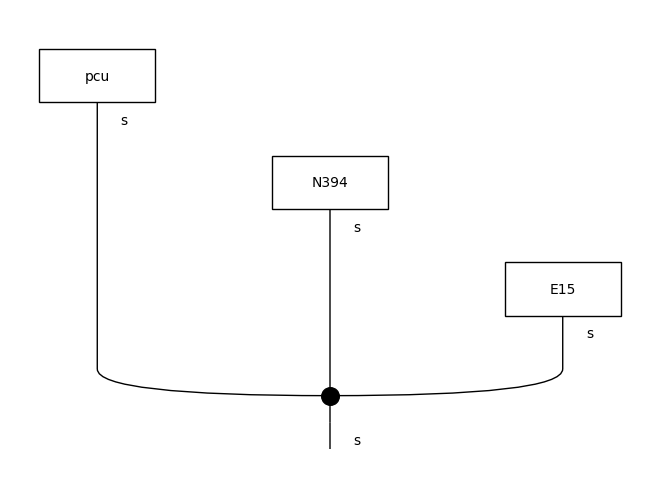

In [13]:
from lambeq import spiders_reader

reader = spiders_reader

train_diagrams = reader.sentences2diagrams(train_data)
train_diagrams[0].draw()
val_diagrams = reader.sentences2diagrams(val_data)

### 3. Create parameterized quantum circuit

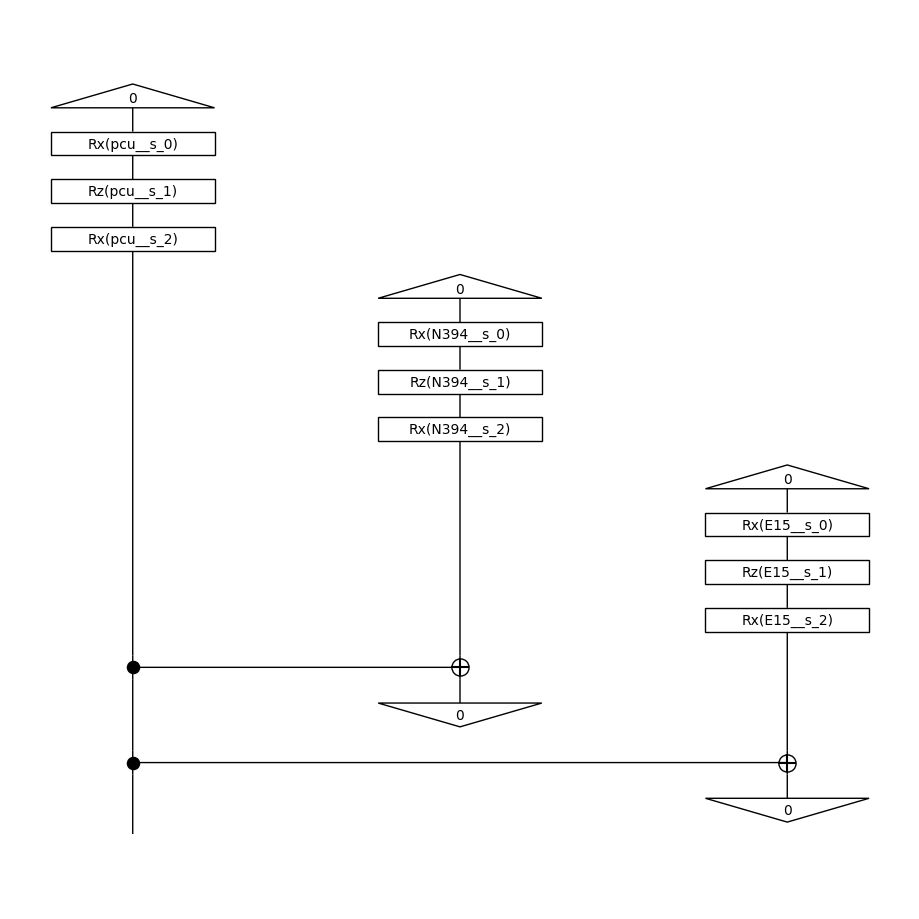

In [14]:
from lambeq import AtomicType, IQPAnsatz

ansatz = IQPAnsatz({AtomicType.NOUN: 1, AtomicType.SENTENCE: 1},
                   n_layers=1, n_single_qubit_params=3)

train_circuits = [ansatz(diagram) for diagram in train_diagrams]
train_circuits[0].draw(figsize = (9,9))

val_circuits =  [ansatz(diagram) for diagram in val_diagrams]


### 4. Choosing backend and define evaluation metric

In [15]:
from pytket.extensions.qiskit import AerBackend
from lambeq import TketModel
from lambeq import BinaryCrossEntropyLoss

all_circuits = train_circuits+val_circuits

backend = AerBackend()

backend_config = {
    'backend': backend,
    'compilation': backend.default_compilation_pass(2),
    'shots': 8192
}

model = TketModel.from_diagrams(all_circuits, backend_config=backend_config)

bce = BinaryCrossEntropyLoss()
accuracy = lambda y_hat, y: np.sum(np.round(y_hat) == y) / len(y) / 2  

### 5. Train Model

In [16]:
from lambeq import QuantumTrainer, SPSAOptimizer
import numpy as np

EPOCHS = 200
BATCH_SIZE = 30

trainer = QuantumTrainer(
    model,
    loss_function=bce,
    epochs=EPOCHS,
    optimizer=SPSAOptimizer,
    optim_hyperparams={'a': 0.05, 'c': 0.06, 'A':0.01*EPOCHS},
    evaluate_functions={'acc': accuracy},
    evaluate_on_train=True,
    verbose = 'text',
    seed=0
)

from lambeq import Dataset

train_dataset = Dataset(
            train_circuits,
            train_labels,
            batch_size=BATCH_SIZE)

val_dataset = Dataset(val_circuits, val_labels, shuffle=False)

trainer.fit(train_dataset, val_dataset, log_interval=1)


Epoch 1:    train/loss: 2.1229   valid/loss: 1.0221   train/acc: 0.5119   valid/acc: 0.5606
Epoch 2:    train/loss: 3.8884   valid/loss: 1.0534   train/acc: 0.2857   valid/acc: 0.5152
Epoch 3:    train/loss: 1.7082   valid/loss: 1.7018   train/acc: 0.4762   valid/acc: 0.5455
Epoch 4:    train/loss: 0.9863   valid/loss: 1.8857   train/acc: 0.5119   valid/acc: 0.7273
Epoch 5:    train/loss: 2.3729   valid/loss: 0.8868   train/acc: 0.5238   valid/acc: 0.6364
Epoch 6:    train/loss: 1.4999   valid/loss: 2.2966   train/acc: 0.4881   valid/acc: 0.6364
Epoch 7:    train/loss: 1.5881   valid/loss: 1.0289   train/acc: 0.5595   valid/acc: 0.5455
Epoch 8:    train/loss: 2.5625   valid/loss: 2.1065   train/acc: 0.6786   valid/acc: 0.7576
Epoch 9:    train/loss: 2.6623   valid/loss: 2.0572   train/acc: 0.7083   valid/acc: 0.6061
Epoch 10:   train/loss: 2.1987   valid/loss: 1.6057   train/acc: 0.5952   valid/acc: 0.4242
Epoch 11:   train/loss: 1.1239   valid/loss: 1.1662   train/acc: 0.5476   valid/

In [17]:
history = {
    'train_loss': trainer.train_epoch_costs,
    'val_loss': trainer.val_costs,
    'train_acc': trainer.train_eval_results['acc'],
    'val_acc': trainer.val_eval_results['acc']
}

Accuracy:  0.8929/ 0.8182
Loss:  0.2164/ 0.2785


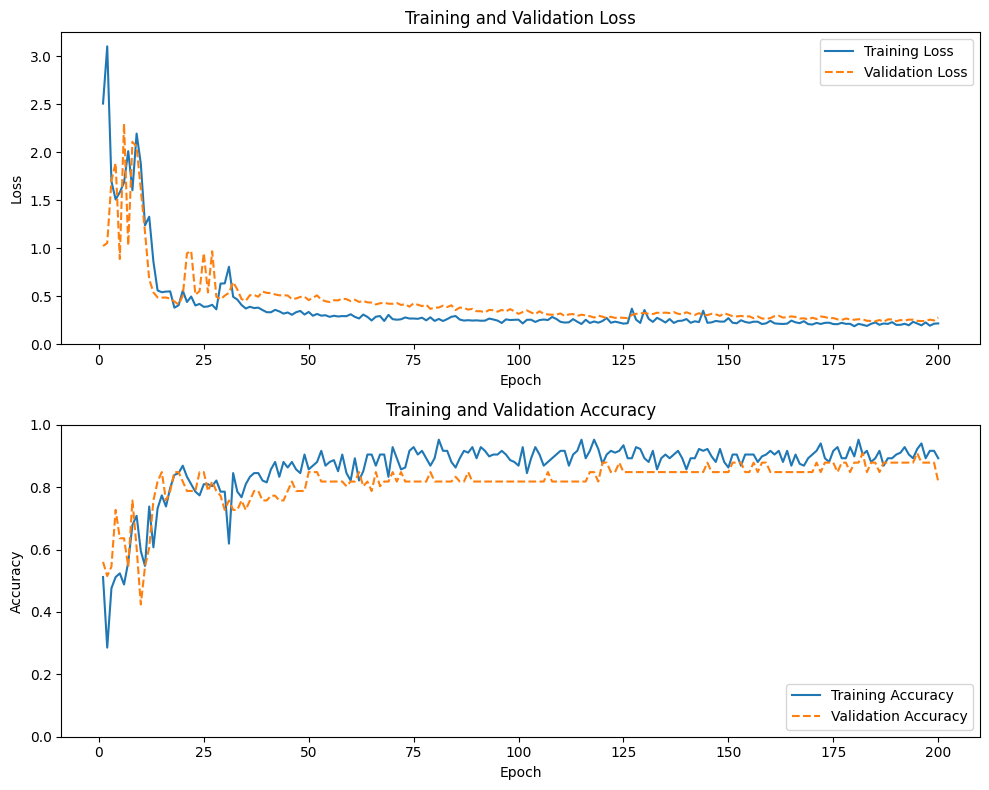

In [19]:
import matplotlib.pyplot as plt

train_acc = history['train_acc']
train_loss = history['train_loss']
val_acc = history['val_acc']
val_loss = history['val_loss']

final_train_acc = history['train_acc'][-1]
final_train_loss = history['train_loss'][-1]
final_val_acc = history['val_acc'][-1]
final_val_loss = history['val_loss'][-1]

print(f'Accuracy: {final_train_acc: .4f}/{final_val_acc: .4f}')
print(f'Loss: {final_train_loss: .4f}/{final_val_loss: .4f}')

EPOCHS = len(train_acc)
epochs_range = range(1, EPOCHS + 1)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

ax1.plot(epochs_range, train_loss, label='Training Loss')
ax1.plot(epochs_range, val_loss, label='Validation Loss', linestyle='--')
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_ylim(bottom=0) 
ax1.legend()

ax2.plot(epochs_range, train_acc, label='Training Accuracy')
ax2.plot(epochs_range, val_acc, label='Validation Accuracy', linestyle='--')
ax2.set_title('Training and Validation Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_ylim(bottom=0, top = 1) 
ax2.legend(loc = 'lower right')

plt.tight_layout()
plt.show()